# Ejemplo de Red Completamente Conectada.

Este es un ejemplo de Red Completamente Conectada (MLP) con el objetivo pronósticar los valores futuros de una serie temporal. 

Los datos son la concentración media diaria de dióxido de nitrógeno en la estación de monitorización de calidad del aire de Arturo Soria (Madrid, España) y se extienden desde 01-01-2010 hasta 31-05-2018.

## Importar librerías

In [ ]:
import os
import math
from math import sqrt
import sys
import numpy
import numpy as np
import random
import scipy.stats
from pylab import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from time import time

import matplotlib.dates as mdates

In [ ]:
import pandas as pd

In [ ]:
import matplotlib as mpl

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout,Convolution1D, MaxPooling1D, Flatten
from tensorflow.python.keras.layers import BatchNormalization, Activation, ZeroPadding1D, ReLU, add
from tensorflow.python.keras import Sequential, Input, Model
from tensorflow import keras

#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation, Flatten

#import keras.backend as K

## Leer los datos

In [ ]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1CFSwvzcAvSrALYRcKuYs2Mf7Bwe9C3Pj'}) # replace the id with id of file you want to access
downloaded.GetContentFile('datos_16AS_NO2.txt')

In [ ]:
values = pd.read_csv('datos_16AS_NO2.txt', sep="\t", header=1)

In [ ]:
print(len(values))

3072


## Se definen algunos parámetros. 

In [ ]:
dataset = values

sample_size = 365 # Tamaño del vector de variables indpendientes.
ahead = 2 # Números de valores pronosticados a futuro.
nepochs=25 # Número de épocas de entramiento. 

In [ ]:
print(dataset.shape[0])

3072


Se cambian los tamaños de las fuentes.

In [ ]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'
mpl.rcParams['axes.labelsize'] = 'large'

In [ ]:
# Se verifica que la longitud de la variable independiente no es mayor que el tamaño de los datos.
assert 0 < sample_size < len(dataset)

## Se crean las variables independientes y dependientes.

In [ ]:
# Se crea un ventana de tamaño sample_size que avanza desde el principio 
# de la serie temporal para crear el vector de variables independiente.
dataset = np.asarray(dataset)
	
X = np.atleast_3d(np.array([dataset[start:start + sample_size] 
			for start in range(0, dataset.shape[0]-sample_size)]))

# Se crea la variable dependiente.
y = dataset[sample_size:] 

In [ ]:
print(X.shape,y.shape)

(2707, 365, 1) (2707, 1)


## Se crean los conjuntos de entrenamiento y test para las variables independiente y dependientes.



In [ ]:
test_size = 2*365 # tamaño del conjunto de entrenamiento

In [ ]:
trainX, testX = X[:-test_size], X[-test_size:]
trainY, testY = y[:-test_size], y[-test_size:]

In [ ]:
print(trainX.shape,testX.shape)
print(trainY.shape,testY.shape)

(1977, 365, 1) (730, 365, 1)
(1977, 1) (730, 1)


In [ ]:
nextSteps = np.empty((ahead+1,sample_size,1))
nextSteps[0,:,:]= np.atleast_3d(np.array([dataset[start:start + sample_size] 
	for start in range(dataset.shape[0]-sample_size,dataset.shape[0]-sample_size+1)]))

In [ ]:
print(nextSteps.shape)

(3, 365, 1)


## Definición de la red neuronal.

In [ ]:
# 2 capas ocultas con 64 y 32 (y 64) neuronas, respectivamente
neurons = [64, 32] 

# Creamos la base del modelo
model = Sequential() 

# Ponemos una primera capa oculta con 64 neuronas
model.add(Dense(neurons[0], activation='relu', input_shape=(sample_size, 1)))
print(model.layers[-1].output_shape)
	
# Incorporamos una segunda capa oculta con 32 neuronas
model.add(Dense(neurons[1], activation='relu'))
print(model.layers[-1].output_shape)
	
# Aplanamos los datos para reducir la dimensionalidad en la salida
model.add(Flatten())

# A\~nadimos la capa de salida de la red con activacion lineal
model.add(Dense(1, activation='linear'))
print(model.layers[-1].output_shape)

(None, 365, 64)
(None, 365, 32)
(None, 1)


Se muestra un resumen de la red creada.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 365, 64)           128       
_________________________________________________________________
dense_1 (Dense)              (None, 365, 32)           2080      
_________________________________________________________________
flatten (Flatten)            (None, 11680)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11681     
Total params: 13,889
Trainable params: 13,889
Non-trainable params: 0
_________________________________________________________________


Se compila el modelo, incluyendo la elección del optimizador y del error que se minimizará durante el entrenamiento. A continuación se entrena el modelo, almacenando la información del error en la variable "history". 

In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [ ]:
history=model.fit(trainX, trainY, epochs=nepochs, batch_size=64, validation_data=(testX, testY), verbose=2) 

Epoch 1/25
31/31 - 2s - loss: 403.2430 - mse: 403.2430 - val_loss: 234.3249 - val_mse: 234.3249
Epoch 2/25
31/31 - 1s - loss: 234.0887 - mse: 234.0887 - val_loss: 221.3571 - val_mse: 221.3571
Epoch 3/25
31/31 - 1s - loss: 221.7312 - mse: 221.7312 - val_loss: 212.5947 - val_mse: 212.5947
Epoch 4/25
31/31 - 1s - loss: 208.9995 - mse: 208.9995 - val_loss: 208.0895 - val_mse: 208.0895
Epoch 5/25
31/31 - 1s - loss: 200.7696 - mse: 200.7696 - val_loss: 203.8242 - val_mse: 203.8242
Epoch 6/25
31/31 - 1s - loss: 198.1961 - mse: 198.1961 - val_loss: 205.1232 - val_mse: 205.1232
Epoch 7/25
31/31 - 1s - loss: 185.3121 - mse: 185.3121 - val_loss: 225.3142 - val_mse: 225.3142
Epoch 8/25
31/31 - 1s - loss: 179.7983 - mse: 179.7983 - val_loss: 198.1062 - val_mse: 198.1062
Epoch 9/25
31/31 - 1s - loss: 172.9781 - mse: 172.9781 - val_loss: 190.6257 - val_mse: 190.6257
Epoch 10/25
31/31 - 1s - loss: 172.4650 - mse: 172.4650 - val_loss: 204.4880 - val_mse: 204.4880
Epoch 11/25
31/31 - 1s - loss: 163.4169

Se pronostican los resultados para el conjunto de test.

In [ ]:
pred = model.predict(testX)

Se calcula el error de la predicción.

In [ ]:
print('ECM: %.4f' % (mean_squared_error(testY, pred) ))
print('EAM: %.4f' % (mean_absolute_error(testY, pred)))

ECM: 189.3428
EAM: 10.7311


## Visualización de resultados

En la siguiente gráfica se visualiza la evolución del error para el conjunto de entrenamiento y test en función de las épocas.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


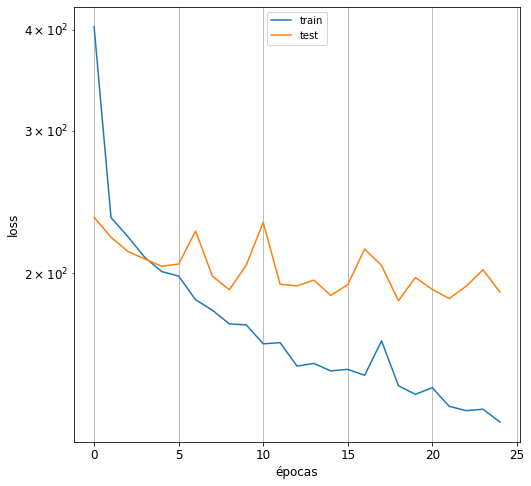

In [ ]:
plt.figure(1, figsize=(8,8))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.yscale("log")
#plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('épocas')
plt.grid()
#plt.xlim(-0.5,20.1)
plt.legend(['train', 'test'], loc='upper center')

from google.colab import files
plt.savefig('loss_MLP.eps')
#files.download('loss_MLP.eps') # Descomentar para descargar localmente

### Se calcula los nuevos valores (futuro).


In [ ]:
newValues = np.zeros(ahead)
temp=np.zeros(sample_size)

for i in range(ahead):
	#print('ahead',i)

	#print('prediccion ', model.predict(nextSteps[None,i,:]), model.predict(nextSteps[None,i,:]))
	temp=nextSteps[i,1:,:]
	#print(temp, len(temp))
	temp = np.append(temp,model.predict(nextSteps[None,i,:]), axis=0)
	newValues[i] = model.predict(nextSteps[None,i,:])
	#print(temp, len(temp))

	#print(nextSteps[i,:,:])
	nextSteps[i+1,:,:]= temp
	#print(nextSteps[i+1,:,:])

print('newValues: ', *newValues, sep=', ')

newValues: , 41.00176239013672, 26.53188705444336


En la siguiente gráfica se visualizan los datos originales y el pronóstico de la red neuronal para el conjunto de entrenamiento. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript bac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

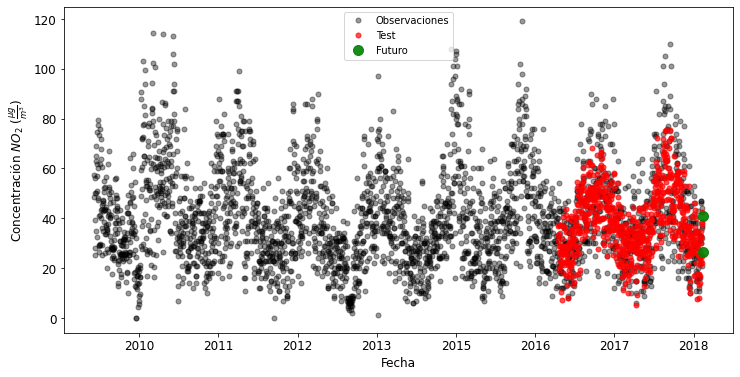

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6)) # (18,6)
plt.figure(1)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
daystart = pd.datetime(2010, 1, 1)
testdaystart = daystart + pd.DateOffset(dataset.shape[0]-len(pred)) 
dayendstart =  pd.datetime(2018,6,1)

plt.plot(pd.date_range(daystart, periods=len(values), freq='D'), values, 'ko', markersize=5, alpha=0.4, label='Observaciones')
plt.plot(pd.date_range(testdaystart, periods=len(pred), freq='D'), pred, 'ro', markersize=5, alpha=0.7, label='Test')

if ahead !=0:
  plt.plot( pd.date_range(dayendstart, periods=ahead, freq='D'), newValues, "go", alpha=0.9,markersize=10, label='Futuro')

plt.ylabel(r"Concentración $NO_2$ ($\frac{\mu g}{m^3}$)")
plt.xlabel('Fecha')
ax.legend()

from google.colab import files
plt.savefig('ANN_pronostico.eps')
files.download('ANN_pronostico.eps') # Descomentar para descargar localmente

## Propuestas adicionales.

* Modificar la red neuronal añadiendo capas y verificar si el error se reduce.
* Añadir dropout a la red.
* Crea un MLP con entrada bivariantes: NO2 y O3 de Arturo Soria para generar un pronóstico bivariante.


